In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from pandas.tools.plotting import table
from scipy.stats import mannwhitneyu as mannu
from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
def logMean(x):
    tmp = np.mean(x)
    return 10*np.log10(tmp)
def bar_plot(data,group,hue='state_name',col=None,
             nBoot=1000,col_order=None,row_order=['delta','theta'],
             row='power_band'):
    hue_order = groupOrders[hue]
    group_order = groupOrders[group]
    palette = palDict[hue]
    yCol = 'CWT Mean Power'
    if len(data[group].unique())>4:
        legend_y = 1.2
        cWrap=4
    else:
        legend_y = 1.3
        cWrap=2
    if row is not None:
        cWrap=None
    g = sns.catplot(kind='bar',data=data,x=group,y=yCol,col=col,hue=hue,
                    margin_titles=True,row=row,n_boot=nBoot,order=group_order,
                    row_order=row_order,col_order=col_order,height=5,aspect=2,col_wrap=cWrap,
                    hue_order=hue_order,legend=False,palette=palette)
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('CWT Band Power')
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    legend = g.axes.flat[0].legend(loc='center', bbox_to_anchor=(1.25, 0),
                        ncol=1, fancybox=True, shadow=True,fontsize=18)
    g.set_axis_labels('','')
    g.fig.text(0.01,0.5,'Power (dB)',rotation=90,va='center',fontsize=24)
    g.fig.text(0.5,0.03,'Frequency (Hz)',ha='center',fontsize=24)
    g.despine()
    return g
                    

In [3]:
def bootstrap(data,n_boot=1000,bootfun=np.mean):
    stats = []
    N = len(data)
    for i in range(n_boot):
        stats.append(bootfun(np.random.choice(data,N,replace=True)))
    sem = np.std(stats)
    mean = np.mean(stats)
    ci = (np.percentile(stats,2.5),np.percentile(stats,97.5))
    return mean, sem, ci

In [4]:
def permutation_test(pooled,n,m,delta,myfun=lambda x,y:np.mean(x)-np.mean(y),n_boot=1000):
    N = n+m
    stats = []
    for i in range(n_boot):
        np.random.shuffle(pooled)
        stats.append(myfun(pooled[:n],pooled[n:]))
    stats = np.array(stats)
    diffCount = (np.abs(stats)>delta).sum()
    pval = float(diffCount)/float(n_boot)
    return pval

In [100]:
sns.set_style('whitegrid')
sns.set_context('poster')
gender_palette = sns.color_palette(['#1258DC','#C21460']) # M F
geno_palette = sns.color_palette(['#8601AF','#FC600A']) # WT Df1
gengen_palette = sns.color_palette(['#8601AF','#C91BFE','#FC600A','#FE9F6D']) # WT_F WT_M Df1_F Df1_M 
anim_palette = sns.color_palette(['#D84DFF','#C91BFE','#8601AF','#52006B','#FDBA96','#FE9F6D','#FC600A','#BF4503']) # RW7 RW8 RW9 RW10 RZ7 RZ8 RZ9 RZ10
specAnim_palette = sns.color_palette(['#305A30','#0A3409','#A70F01','#882216']) # RW9 RW10 RZ9 RZ10
bandAnim_palette = sns.color_palette(['#D84DFF','#FDBA96','#C91BFE','#FE9F6D','#8601AF','#FC600A','#52006B','#BF4503']) # RW7 RZ7 RW8 RZ8 RW9 RZ9 RW10 RZ10
epoch_palette = sns.color_palette(['#2E2FE3','#FB8604','#448D76']) # Baseline Saline Ketamine
state_palette = sns.color_palette(['#448D76','#FB8604','#EA202C'])
pairPal = sns.color_palette(['#DD3F97','#BD56A0','#55C3EA','#4653A4'])
palDict = {'genotype':geno_palette,
           'gender': gender_palette,
           'geno_gender':gengen_palette,
#           'animal':anim_palette,
           'epoch_name':epoch_palette,
           'spec_animal':specAnim_palette,
           'state_name':state_palette,
           'Name':bandAnim_palette}
groupOrders = {'genotype':['WT','Df1'],
               'gender':['M','F'],
               'geno_gender':['WT_M','WT_F','Df1_M','Df1_F'],
    #           'animal':['RW7','RW8','RW9','RW10','RZ7','RZ8','RZ9','RZ10'],
               'epoch_name':['Baseline','Saline','Ketamine'],
               'spec_animal':['RW9','RW10','RZ9','RZ10'],
               'state_name':['NREM','Rest','Active'],
               'Name':['WT1','DF1','WT2','DF2','WT3','DF3','WT4','DF4']}

In [6]:
bandList = []
project_path = '/data/Projects/'
figure_dir = project_path+'rn_Schizophrenia_Project/SFN2018_Figures/'

for dirpath,dirnames,files in os.walk(project_path):
    for name in files:
        if name.endswith('sleepBandPowerMatrix.csv'):
            bandList.append(os.path.join(dirpath+'/'+name))

In [28]:
exclusions = ('state_name=="Artifact"',
              'state_name=="Transition"',
              'state_name=="REM"',
              'animal=="RW9" and (state_name=="Active" or tetrode==6)', # allow Active in trace plots
              'animal=="RW7" and day==5',
              'animal=="RZ7" and day==3',
              'animal=="RZ9" and day==5 and tetrode==8')
qStr = 'not ('+') and not ('.join(exclusions)+')'

In [29]:
# Get data from CSV, add columns
bandMat = pd.DataFrame()
for rf in bandList:
    tmp = pd.read_csv(rf)
    bandMat = bandMat.append(tmp)
bandMat = bandMat.reset_index(drop=True)
print('Data Loaded!')
# Change Epoch Names (Baseline, Saline, Ketamine, Home)
# Change Band Names (Delta, Theta)
epochDict = {'Sleep':'Baseline','Saline':'Saline','Ketamine':'Ketamine','Home':'Home'}
bandMat['epoch_name'] = bandMat['epoch_type'].map(epochDict)

# Add state names
stateDict = {1:'REM',2:'NREM',3:'Rest',4:'Active',5:'Transition',6:'Artifact'}
bandMat['state_name']=bandMat['sleep_state'].map(stateDict)

animDat = pd.DataFrame(index=['RW7','RW8','RW9','RW10','RZ7','RZ8','RZ9','RZ10'],
                       columns=['name','pair','gender','genotype'],
                       data=[['WT1',1,'F','WT'],['WT2',2,'F','WT'],
                             ['WT3',3,'M','WT'],['WT4',4,'M','WT'],
                             ['DF1',1,'F','Df1'],['DF2',2,'F','Df1'],
                             ['DF3',3,'M','Df1'],['DF4',4,'M','Df1']])
bandMat['Pair'] = bandMat['animal'].map(animDat['pair'].to_dict())
bandMat['Genotype x Gender'] = bandMat['genotype'].map(str) + '_' + bandMat['gender']
bandMat['Name'] = bandMat['animal'].map(animDat['name'].to_dict())
bandMat.rename(inplace=True,columns={'CWT_mean':'CWT Mean Power'})

Data Loaded!


In [31]:
# For each time point mean over tetrodes, only keep important power
# Then exclude and sample
tmp = bandMat.query(qStr)
avgDat = tmp.groupby(['animal','genotype','gender','Genotype x Gender','Name','Pair',
                           'epoch_name','state_name','power_band','day','epoch','tetrode',
                           'epoch_time']).mean().reset_index()

# For each animal, day and state get mean power
newAvgDat = avgDat.groupby(['animal','genotype','gender','Genotype x Gender','Name','Pair',
                            'epoch_name','state_name','power_band','day']).mean().reset_index()

stateCounts = avgDat.groupby(['animal','state_name'])['state_name'].count()
minCounts = {}
for state in avgDat['state_name'].unique():
    minCounts[state]=min(stateCounts[:,state])

# Pick same number of samples from each animal for each state
sampSet = pd.DataFrame()
for name, tmp in avgDat.groupby(['animal','state_name']):
    n_samp = minCounts[name[1]]
    sampSet = sampSet.append(tmp.sample(n_samp))
sampSet = sampSet.sort_values(by=['animal','day'])

In [9]:
# TODO: Really should check if recording time is related to band power (Verify Stable recordings)

In [54]:
# Plot Df1-WT for each pair, use Mann-Whitney U test
pairDiffs = pd.DataFrame()
colNames = ['Gender','Pair','State','WT Mean Delta','WT SEM','WT CI','Df1 Mean Delta',
            'Df1 SEM','Df1 CI','Difference','SD','U-Statistic','p-Value']
n_boot = 5000
for state in sampSet['state_name'].unique():
    for name, data in avgDat.query('state_name=="'+state+'"').groupby(['Pair']):
        
        setWT = data.query('genotype=="WT"')['CWT Mean Power']
        setDF = data.query('genotype=="Df1"')['CWT Mean Power']
        gender = data['gender'].unique()[0]
        if setWT.empty or setDF.empty:
            tmpDiff = np.nan
            tmpSD = np.nan
            pval = np.nan
            stat = np.nan
            if not setWT.empty:
                meanWT,semWT,ciWT = bootstrap(setWT)
            else:
                meanWT = np.nan
                semWT = np.nan
                ciWT = np.nan
            if not setDF.empty:
                meanDF,semDF,ciDF = bootstrap(setDF)
            else:
                meanDF = np.nan
                semDF = np.nan
                ciDF = np.nan
        else:
            meanWT,semWT,ciWT = bootstrap(setWT,n_boot=n_boot)
            meanDF,semDF,ciDF = bootstrap(setDF,n_boot=n_boot)
            tmpDiff = meanDF-meanWT
            tmpSD = np.sqrt((semDF**2) + (semWT**2))
            #pval = permutation_test(np.array(data['CWT Mean Power'].values),len(setWT),len(setDF),tmpDiff,n_boot=n_boot)        
            stat, pval = mannu(setWT,setDF,alternative='two-sided')
        dat = [gender,name,state,meanWT,semWT,ciWT,
               meanWT,semWT,ciWT,tmpDiff,tmpSD,
               stat,pval]
        row = dict(zip(colNames,dat))
        pairDiffs = pairDiffs.append(row,ignore_index=True)
pairDiffs = pairDiffs[colNames]

In [92]:
# Use KW and Kunn's on animals for pairwise analysis
testData = newAvgDat.query('power_band=="theta" and epoch_name=="Baseline"')
datDicts = []
Hdict = {}
KWPval = {}
dunnDict = {}
n_boot = 2000
for state in testData['state_name'].unique():
    groups = []
    toCompare = []
    ids = []
    tmpDF = pd.DataFrame()
    i=0
    for name, data in testData.query('state_name=="'+state+'"').groupby(['Pair']):
        tmp1 = data.query('genotype=="WT"')['CWT Mean Power']
        tmp2 = data.query('genotype=="Df1"')['CWT Mean Power']
        if tmp1.empty:
            meanWT = np.nan
            semWT = np.nan
        else:
            meanWT,semWT,ciWT = bootstrap(tmp1,n_boot=n_boot)
        if tmp2.empty:
            meanDF = np.nan
            semDF = np.nan
        else:
            meanDF,semDF,ciDF = bootstrap(tmp2,n_boot=n_boot)
        if not tmp1.empty and not tmp2.empty:
            groups.append(tmp1)
            groups.append(tmp2)
            toCompare.append((i,i+1))
            ids.append((state,'WT',('%i' % name)))
            ids.append((state,'Df1',name))
            tmpDiff = meanDF-meanWT
            tmpSD = np.sqrt((semDF**2) + (semWT**2))
            i+=2
        else:
            tmpDiff = np.nan
            tmpSD = np.nan
        tmpRow = {'Pair':name,'Gender':animDat[animDat['pair']==name]['gender'].unique()[0],
                  'State':state,'WT Mean Delta':'%0.2f' % meanWT,'WT SEM':'%0.2f' % semWT,'N_WT':len(tmp1),
                  'Df1 Mean Delta':'%0.2f' % meanDF,'Df1 SEM':'%0.2f' % semDF,'N_DF':len(tmp2),
                  'Difference':'%0.2f' % tmpDiff,'SD':'%0.2f' % tmpSD,'spi':state+('%i' % name)}
        datDicts.append(tmpRow)
        
    
    Hstat, pval = kruskal(*groups)
    dunnP = sp.posthoc_dunn(groups,'bonferonni')
    Hdict[state] = '%0.2f' % Hstat
    KWPval[state] = '%0.3g' % pval
    

    arr = []
    for p in toCompare:
        a = ids[p[0]]
        b = ids[p[1]]
        pv = dunnP[p]
        dunnDict[state+a[2]] = '%0.2g' % pv
animStat = pd.DataFrame(datDicts)
animStat['KW p-Value'] = animStat['State'].map(KWPval)
animStat['H-statistic'] = animStat['State'].map(Hdict)
animStat['Dunn p-Value'] = animStat['spi'].map(dunnDict)
cols = ['State','Gender','Pair','WT Mean Delta','WT SEM','Df1 Mean Delta','Df1 SEM','KW p-Value','Difference', 'SD','Dunn p-Value']
animStatOut = animStat[cols].copy()
animStatOut.to_html(figure_dir+'Bar/Condensed_Theta_Littermate_Difference_Stats.html')

In [93]:
col = []
animStatOut = animStatOut.dropna()
for x in pd.to_numeric(animStatOut['Dunn p-Value']):
    if x<=0.001:
        col.append('***')
    elif x<=0.01:
        col.append('**')
    elif x<=0.05:
        col.append('*')
    else:
        col.append(' ')
animStatOut['Sig Stars'] = col
animStatOut['Difference'] = pd.to_numeric(animStatOut.loc[:,'Difference'])

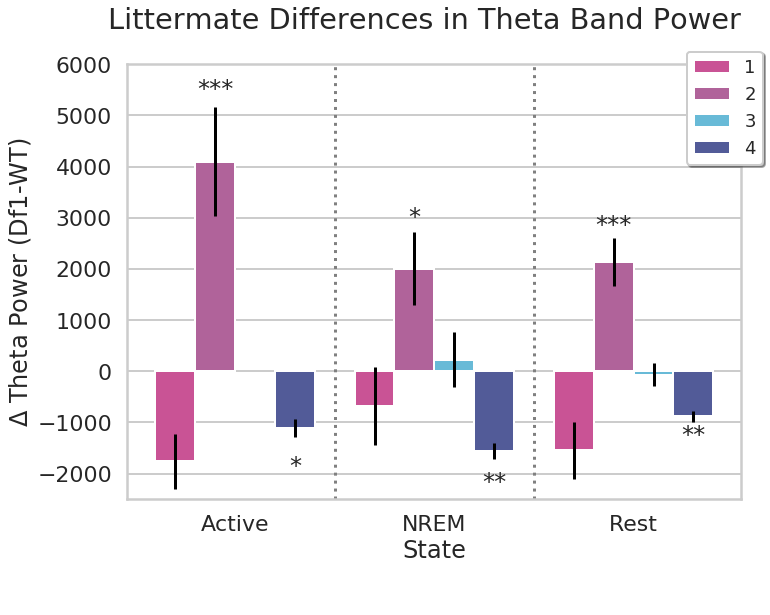

In [110]:
#sns.set_context('poster')
#sns.set_style('whitegrid',rc={'figure.figsize':(11,8.5)})
n_states = len(animStatOut['State'].unique())
n_pairs = len(animStatOut['Pair'].unique())
x_shift = np.linspace(-0.3,0.3,n_pairs)
x_pos = np.sort((
        np.matlib.repmat(np.linspace(0,n_states-1,n_states),1,n_pairs)
        .reshape(n_states,n_pairs)+x_shift).flatten())
heights = pd.to_numeric(animStatOut.loc[:,'Difference']).tolist()
heights.insert(2,np.nan)
yerr = pd.to_numeric(animStatOut.loc[:,'SD']).tolist()
yerr.insert(2,np.nan)
sigStars = animStatOut.loc[:,'Sig Stars'].tolist()
sigStars.insert(2,np.nan)
star_y = np.abs(np.abs(heights)+2*max(yerr))*np.sign(heights)
g = sns.barplot(data=animStatOut,x='State',y='Difference',hue='Pair',palette=pairPal)
g.figure.set_size_inches(11,8)
legend = g.legend(loc='upper right', bbox_to_anchor=(1.05, 1.05),
                  ncol=1, fancybox=True, shadow=True,fontsize=18)
g.set_ylim(-2500,6000)
plt.vlines([.5,1.5],g.get_ylim()[0],g.get_ylim()[1],color='grey',linestyles='dotted')

for x,h,err,s in zip(x_pos,heights,yerr,sigStars):
    if not np.isnan(x) and not np.isnan(h):
        if h<0:
            y = h-5*err
        else:
            y = h+1.2*err
        plt.text(x=x,y=y,s=s,ha='center')
        plt.vlines(x,h-err,h+err,color='k',linestyles='solid')
        
g.figure.suptitle('Littermate Differences in Theta Band Power')
g.set_xlabel('State')
g.set_ylabel('$\Delta$ Theta Power (Df1-WT)')
g.figure.savefig(figure_dir+'Bar/Condensed_Theta_Littermate_Differences.svg',format='svg')

In [ ]:
newMat = pd.DataFrame()
cols = ['Pair','Gender','State','WT Mean Delta','WT SEM','Df1 Mean Delta', 'Df1 SEM','Difference','SD','H-Statistic','KW p-Value','Dunn p-Value']
df = pairDiffs[cols]
i=0
#for col in idcols:
#    newMat.append(pairDiffs[col])
for i,row in df.iterrows():
    newRow = [x if isinstance(x,str) else ('%0.3g' % x if x<1 else '%0.2f' % x) for x in row]
    newMat = newMat.append(dict(zip(cols,newRow)),ignore_index=True)
newMat = newMat[cols]
newMat.to_latex(figure_dir+'Bar/Littermate_Difference_Stats.tex')

In [ ]:
# Plot Animal and Genotype and Genotype x Gender bar graphs
# Compare Genotype x Gender with Kruskal-Wallis and Dunn's post hoc test


In [96]:
# Use KW and Kunn's on animals for pairwise analysis
testData = newAvgDat.query('power_band=="theta" and epoch_name=="Baseline"')
datDicts = []
Hdict = {}
KWPval = {}
dunnDict = {}
dunnStats = pd.DataFrame()
n_boot = 2000
for state in testData['state_name'].unique():
    groups = []
    toCompare = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
    if state is 'Active':
        toCompare = [(0,1),(0,2),(1,2)]
    ids = []
    tmpDF = pd.DataFrame()
    i=0
    names = []
    for name, data in testData.query('state_name=="'+state+'"').groupby(['geno_gender']):
        tmp1 = data['CWT Mean Power']
        if tmp1.empty:
            meanWT = np.nan
            semWT = np.nan
        else:
            tmpGroup = []
            counts = data.groupby('animal')['animal'].count()
            minCount = np.min(counts)
            tmpGroup = data.groupby('animal').apply(lambda x: x.sample(minCount))
            #for anim in data['animal'].unique():
            #    tmpGroup.append(data.query('animal="'+anim+'"').sample(minCount))
            meanPow,semPow,ciPow = bootstrap(tmp1,n_boot=n_boot)
            if not tmpGroup.empty:
                groups
        if not tmp1.empty:
            groups.append(tmp1)
            ids.append((state,name))
            names.append(name)
        tmpRow = {'Genotype':data['genotype'].unique()[0],'Gender':data['gender'].unique()[0],
                  'State':state,'Mean Delta':'%0.2f' % meanPow,'SEM':'%0.2f' % semPow,'N':len(tmp1)}
        datDicts.append(tmpRow)
        
    
    Hstat, pval = kruskal(*groups)
    dunnP = sp.posthoc_dunn(groups,'bonferonni')
    Hdict[state] = '%0.2f' % Hstat
    KWPval[state] = '%0.3g' % pval
    dunnTable = pd.DataFrame(data=dunnP,index=names,columns=names)
    dunnTable['State'] = state
    dunnStats = dunnStats.append(dunnTable)
    
ggStat = pd.DataFrame(datDicts)
ggStat['KW p-Value'] = ggStat['State'].map(KWPval)
ggStat['H-statistic'] = ggStat['State'].map(Hdict)
ggStat.to_html(figure_dir+'Bar/Condensed_Theta_Group_Difference_Stats.html')
dunnStats.to_html(figure_dir+'Bar/Condensed_Theta_Group_Dunn_Stats.html')

/home/roshan/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


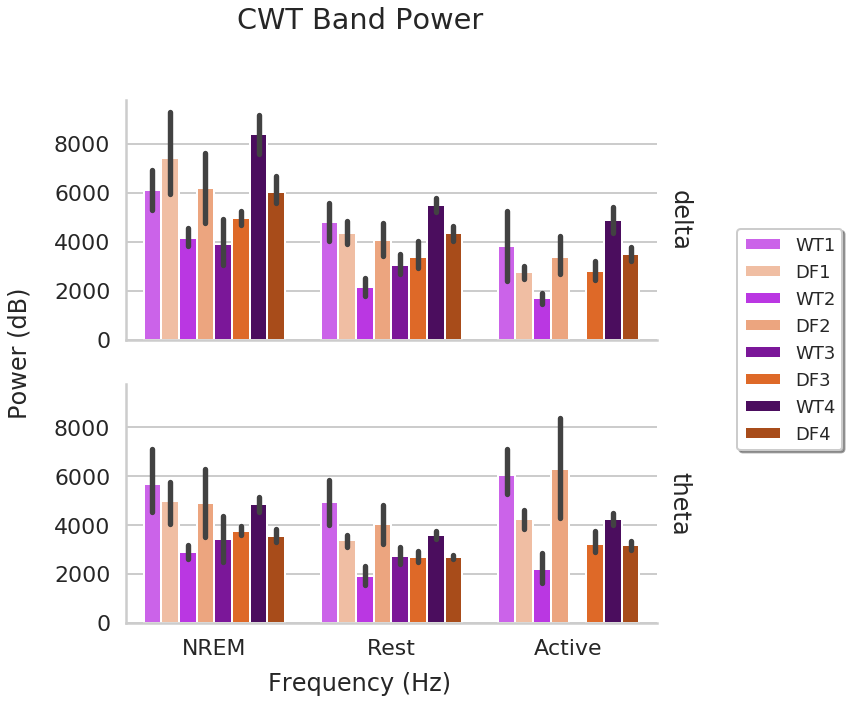

In [88]:
g = bar_plot(newAvgDat,'state_name',hue='Name')
g.savefig(figure_dir+'Bar/Condensed_Animal_BandPower.svg',format='svg')

/home/roshan/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


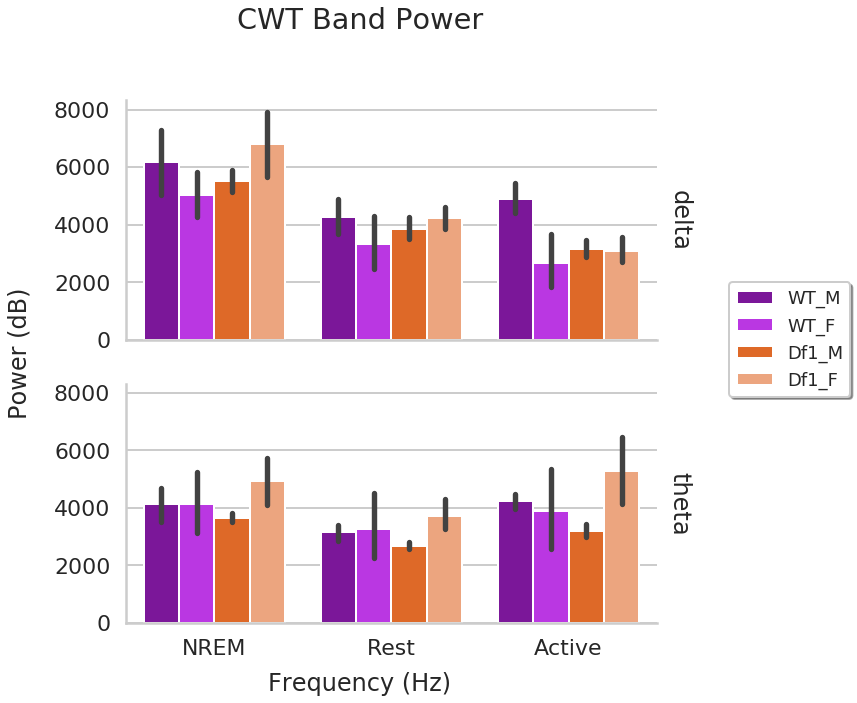

In [91]:
newAvgDat = newAvgDat.rename(columns={'Genotype x Gender':'geno_gender'})
g2 = bar_plot(newAvgDat,'state_name',hue='geno_gender')
g2.savefig(figure_dir+'Bar/Condensed_Group_BandPower.svg',format='svg')